# adding i (integrated) to ARMA

In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import sklearn.metrics

We'll use our old friend the johnson & johnson stock dataset to see how we can use $ARIMA(p,d,q)$

In [2]:
df = pd.read_csv('jj.csv')
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


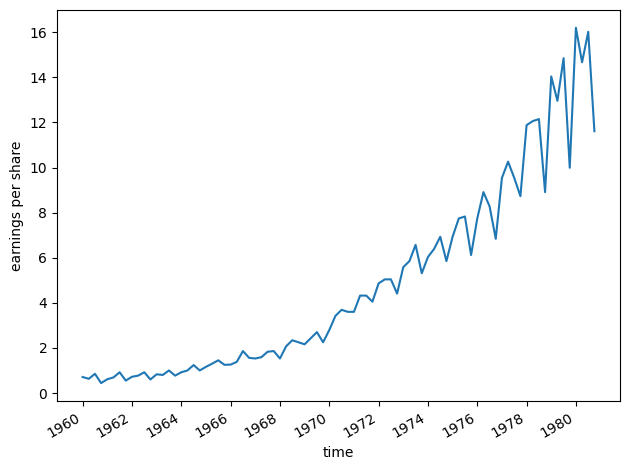

In [3]:
fig, ax = plt.subplots()

ax.plot(df.date, df.data)

ax.set_xlabel('time')
ax.set_ylabel('earnings per share')

plt.xticks(
    np.arange(0, 81, 8), 
    [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980]
)

fig.autofmt_xdate()
plt.tight_layout()

Let us see if it is stationary

In [4]:
adf = sm.tsa.stattools.adfuller(df.data)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic 2.742016573457476
p-value 1.0


adf statistic is not a large negative value, and $p$ value is larger than 0.05, therefore we cannot reject the null hypothesis meaning that our time series is not stationary

We now need to see how many times we must transform (by differencing) to make it stationary

In [5]:
eps_diff = np.diff(df.data, n = 1)
adf = sm.tsa.stattools.adfuller(eps_diff)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic -0.4074097636380252
p-value 0.908854241691134


Still no, $p > 0.05$

In [6]:
eps_diff = np.diff(df.data, n = 2)
adf = sm.tsa.stattools.adfuller(eps_diff)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic -3.5851628747931596
p-value 0.006051099869603576


See how the `n` param changed from `1` to `2` this is the times numpy will make the diff. Therefore we can see that if we make `2` diffs, we can reject the null hypothesis a state that our dataset is stationary after two differencings. Now we know that $d = 2$

In [7]:
def optimize_arima(
        endog: pd.Series | list, order_l: list, d: int) -> pd.DataFrame:
    '''
    Given a list of combinations of p,q test different combinations of arma
    orders, and compare them against each other using Akaike Information
    criterion.

    :param endog typing.Union[pd.Series, list]: the observed time-series process
    :param order_l list: list of all combinations of p and q
    :param d int: number of times the dataset needs to be diff to become 
                  stationary 

    :returns: dataframe with two columns, one the combination of p and q,
        the other the AIC score, the dataframe is already sorted.
    :rtype: pd.DataFrame
    '''

    results = []

    for order in order_l:
        try:
            model = sm.tsa.statespace.SARIMAX(
                endog, 
                order = (order[0], d, order[1]),
                simple_differencing = False,
            )
            model = model.fit(disp = False)
        except:
            continue
    
        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    # sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by = 'AIC', ascending = True)
    result_df = result_df.reset_index(drop = True)

    return result_df

Now let's make the combinations we will try in the model (meaning the diff p and q values we will test)

In [8]:
ps = range(0, 4) 
qs = range(0, 4) 
d = 2

order_l = list(itertools.product(ps, qs))
order_l

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [9]:
df.tail()

,date,data
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02
83,1980-10-01,11.61


Since we will predict 1980 we will train only with all data until 1979, meaning we need to create the training set 

In [10]:
train = df.data[:-4]
train.tail()

75     8.91
76    14.04
77    12.96
78    14.85
79     9.99
Name: data, dtype: float64

In [11]:
result_df = optimize_arima(train, order_l, d)
result_df

/Users/bsantanad/development/n/time-series/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/bsantanad/development/n/time-series/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/bsantanad/development/n/time-series/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/bsantanad/development/n/time-series/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as sta

,"(p,q)",AIC
0,"(3, 3)",115.268926
1,"(3, 1)",115.624980
2,"(3, 2)",115.672007
3,"(3, 0)",154.430620
4,"(0, 3)",194.654716
5,"(0, 2)",209.274571
6,"(2, 3)",220.666950
7,"(1, 3)",228.267677
8,"(1, 2)",228.935827
9,"(2, 2)",229.974755


So the combination with a less AIC is the first one $(3,3)$, let's try to fit the model with these parameters

In [16]:
model = sm.tsa.statespace.SARIMAX(
    train, 
    order = (3, 2, 3),
    simple_differencing = False,
)
model = model.fit(disp = False)
residuals = model.resid

/Users/bsantanad/development/n/time-series/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/bsantanad/development/n/time-series/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


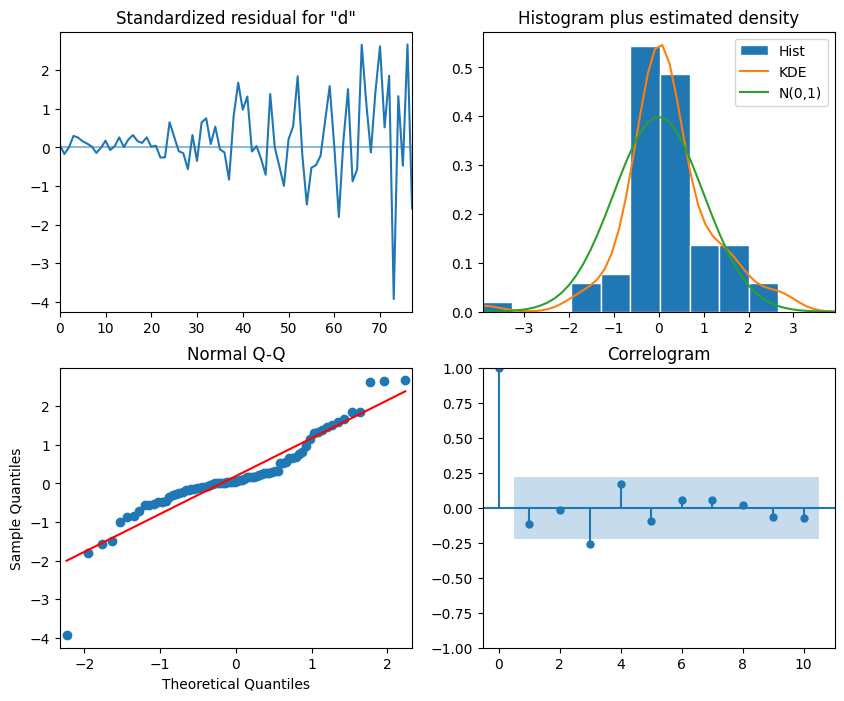

In [17]:
model.plot_diagnostics(figsize=(10, 8));

from a qualitative standpoint, it seems that our residuals are close to white noise, which is a good sign, as it means that the model’s errors are random. This because in the top left plot, we can see that there is no trend, the top right looks kind of like a normal distribution, in the Q-Q plot (bottom left) the blue line and red overlaps, meaning that our error behave like a normal distribution (white noise), and in the bottom right, we can see that even though there is high correlation at lag 3, it is not preceded by any correlation so most likely it is random.

Now we need to get the Ljung-Box statistic to see if the residuals are correlated

In [20]:
sm.stats.acorr_ljungbox(residuals, lags = range(1, 11))

,lb_stat,lb_pvalue
1,1.720379,0.189644
2,1.722922,0.422544
3,7.306020,0.062758
4,9.289629,0.054254
5,9.920515,0.077519
6,10.157293,0.118182
7,10.405758,0.166722
8,10.437772,0.235634
9,10.778933,0.291167
10,11.215738,0.340959


Running the Ljung-Box test on the first 10 lags of the model’s residuals returns a list of p-values that are all larger than 0.05. Therefore we do not reject the null hypothesis meaning that the residuals are not correlated, just like white noise

Everything looks pretty good but our job is not finished, we need to set a baseline with what to compare our prediction against and we need to actually make the prediction with our $ARIMA(3,2,3)$ model